# What Is NLP?

In [132]:
sample = ['Natural Language Processing (NLP) is a set of methods for extracting information from text.',
          'But is text not already data and what would we extract?',
          'It is data, however it is represented as a continuous string of text like'
          'the one you are reading right now.',
          'The issue here is that statistics use numbers as input.',
          'So how do we make numbers out of text?',
          'Usually we break down the text into words.',
          'We can then one-hot encode the words and build a binary matrix.',
          'The columns of the matrix are the tokens, while the rows are the texts.',
          'We can then use the binary matrix as input to a range of numeric functions.']

# Tokenization

The most basic form of tokenization is splitting by whitespace:

In [133]:
import re

sample[0].split()

['Natural',
 'Language',
 'Processing',
 '(NLP)',
 'is',
 'a',
 'set',
 'of',
 'methods',
 'for',
 'extracting',
 'information',
 'from',
 'text.']

However, note that the `(NLP)` token also includes the parentheses. Also, the `text.` token includes the punctuation at the end. We could turn to another basic method for splitting text - regular expressions:

In [134]:
def tokenize_regex(regex, text):
    return [t.lower() for t in re.split(regex, text) if t != '']

In [135]:
punct_whitesp = re.compile(r'\s|[\.\(\)\?]')
tokenize_regex(punct_whitesp, sample[0])

['natural',
 'language',
 'processing',
 'nlp',
 'is',
 'a',
 'set',
 'of',
 'methods',
 'for',
 'extracting',
 'information',
 'from',
 'text']

That looks even better. Note that we also made all tokens in lowercase such that `Natural` will match with `natural`. However, in reality, texts are rarely so clean. They contain:

* Special characters;
* Random new lines, tabs or other whitespace characters;
* Improperly scanned characters (e.g. '§' instead of 'S');
* Foreign words;
* Tpyos;

Here is one example:

In [136]:
import nltk
path = nltk.data.find('corpora/unicode_samples/polish-lat2.txt')
with open(path, 'r', encoding='latin2') as file:
    unicode_sample = file.read()

In [137]:
print(unicode_sample.encode('unicode_escape'))

b'Pruska Biblioteka Pa\\u0144stwowa. Jej dawne zbiory znane pod nazw\\u0105\\n"Berlinka" to skarb kultury i sztuki niemieckiej. Przewiezione przez\\nNiemc\\xf3w pod koniec II wojny \\u015bwiatowej na Dolny \\u015al\\u0105sk, zosta\\u0142y\\nodnalezione po 1945 r. na terytorium Polski. Trafi\\u0142y do Biblioteki\\nJagiello\\u0144skiej w Krakowie, obejmuj\\u0105 ponad 500 tys. zabytkowych\\narchiwali\\xf3w, m.in. manuskrypty Goethego, Mozarta, Beethovena, Bacha.\\n'


That's why an extensive work must be performed to clean the text and tokenize it. The tokenization methods may also differ depending on the subject matter, the types of texts and the qunatity of documents. Sometimes this task constitutes the bulk of the work (the actual modelling being just the 'cherry on the top' of that linguistic Sunday
desert).

Once, we have performed tokenization, we can further optimize our array of tokes. Here is how:

# Stemming
look at the following tokens: `go`, `going`. They represent different strings, but have the same meaning. What can we do about this?


In [138]:
porter = nltk.PorterStemmer()
for token in ['go', 'going']:
    print(f'The initial for is: {token}, but after stemming, it becomes: {porter.stem(token)}')

The initial for is: go, but after stemming, it becomes: go
The initial for is: going, but after stemming, it becomes: go


We can use this technique for text normalization if we want to focus on the meaning rather than the morphology of the text.

Let's go back to our initial sample text:

In [139]:
stem_example = [tokenize_regex(punct_whitesp, sent) for sent in sample[:2]]

In [140]:
stem_example

[['natural',
  'language',
  'processing',
  'nlp',
  'is',
  'a',
  'set',
  'of',
  'methods',
  'for',
  'extracting',
  'information',
  'from',
  'text'],
 ['but',
  'is',
  'text',
  'not',
  'already',
  'data',
  'and',
  'what',
  'would',
  'we',
  'extract']]

Before we start using the industry-standard libraries, we can vectorize the tokenized sentences like so:

In [141]:
import pandas as pd

def count_vectorize(tokenized_text):
    columns = set([t for line in tokenized_text for t in line])
    line_token_matrix = pd.DataFrame(columns=columns)
    for line in tokenized_text:
        to_append = pd.DataFrame([[1 if t in line
                                   else 0
                                   for t in columns]],
                                 columns=columns)
        line_token_matrix = line_token_matrix.append(to_append,
                                                 ignore_index=True)
    return line_token_matrix

In [142]:
stem_example_matrix = count_vectorize(stem_example)

In [143]:
stem_example_matrix

,a,information,extract,and,set,is,language,data,from,we,...,nlp,processing,of,text,methods,already,natural,extracting,but,not
0,1,1,0,0,1,1,1,0,1,0,...,1,1,1,1,1,0,1,1,0,0
1,0,0,1,1,0,1,0,1,0,1,...,0,0,0,1,0,1,0,0,1,1


Here are all the tokes in our matrix. Note that `extract` and `extracting` are separate features). Let's plot all the term frequencies:

In [144]:
import matplotlib.pyplot as plt

def plot_frequencies(count_matrix):
    to_plot = count_matrix.sum()
    fig = plt.figure(figsize=(12, 6))
    plt.barh(to_plot.index, to_plot.values)
    plt.show()

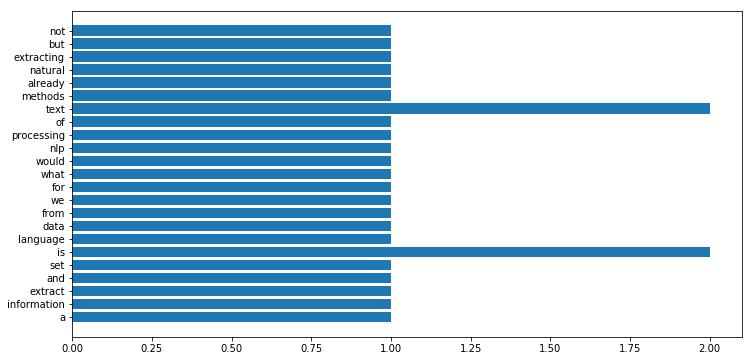

In [145]:
plot_frequencies(stem_example_matrix)

Now, let's stem the tokens and vectorize again:

In [146]:
stem_example = [[porter.stem(token) for token in tokenize_regex(punct_whitesp, sent)] for sent in sample[:2]]

In [147]:
stem_example_matrix = count_vectorize(stem_example)

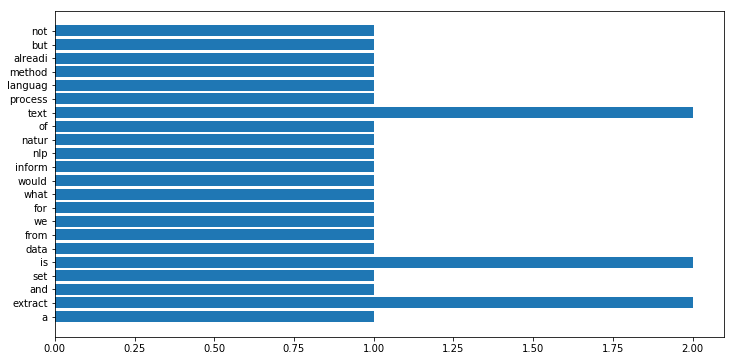

In [148]:
plot_frequencies(stem_example_matrix)

Now, the term `extract` is counted twice based on semantics and not morphology.

But what can we actually do with that binary matrix?

# TFIDF
Suppose we have a group of texts. We want to figure out what are the important terms in each text. That will allow us to infer what the text is about. How can we achieve that? Intuition tells us that terms that are generally rare throughout a corpus (a group of texts), but are frequent in a particular text could be the most important. We can express this intuition as:

$tfidf(t, d, D) = tf(t, d) idf(t, D)$

Where $tf(t, d)$ is the term frequency for a single document. It is defined as:

$tf(t, d) = 0.5 + 0.5\frac{f(t, d)}{max \{f_{t', d} : t' \in d \}}$

The inverse corpus document frequency $idf(t, D)$ is defined as:

$idf(t, D) =  log \frac{N}{|\{d \in D : t \ d\}|}$

Hence the etymology of the name - term frequency inverse document frequency (TFIDF). Let's appy this method to our text:

In [149]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english')

In [150]:
tfidf = tfidf_vectorizer.fit_transform(sample)

In [151]:
tfidf_vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents='ascii', sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

Let's use our TFIDF vectorizer and derive the 3 most important terms for each sentence in our sample:

In [152]:
from collections import defaultdict
tfidf_result = defaultdict(list)

top_n = 3

for i, line in enumerate(sample):
    tfidf_result['doc'].append(line)
    for j in range(top_n):
        feature_names = tfidf_vectorizer.get_feature_names()
        term_df = test_df = pd.DataFrame(tfidf.getrow(i).todense(),
                                         columns=feature_names)
        term = term_df.loc[0].sort_values(ascending=False).reset_index()
        tfidf_result[f'term_{j+1}'].append(term.loc[j].values[0])
        tfidf_result[f'importance_{j+1}'].append(term.loc[j].values[1])

In [153]:
pd.DataFrame(tfidf_result)

,doc,term_1,importance_1,term_2,importance_2,term_3,importance_3
0,Natural Language Processing (NLP) is a set of ...,methods,0.346371,set,0.346371,natural,0.346371
1,But is text not already data and what would we...,extract,0.698669,data,0.590107,text,0.404519
2,"It is data, however it is represented as a con...",right,0.376659,string,0.376659,continuous,0.376659
3,The issue here is that statistics use numbers ...,issue,0.491466,statistics,0.491466,use,0.415100
4,So how do we make numbers out of text?,make,0.698669,numbers,0.590107,text,0.404519
5,Usually we break down the text into words.,usually,0.572730,break,0.572730,words,0.483737
6,We can then one-hot encode the words and build...,hot,0.448740,build,0.448740,encode,0.448740
7,"The columns of the matrix are the tokens, whil...",tokens,0.469360,texts,0.469360,columns,0.469360
8,We can then use the binary matrix as input to ...,functions,0.419612,numeric,0.419612,range,0.419612


# Word2Vec

# Semantic Analysis and Grouping